In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import time
import sys
import multiprocessing as mp

def gaussian(x, C, mu, sigma):
    return C*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

SET_N_TRHEADS = 4

# Cluster generation

Text(0, 0.5, 'Row')

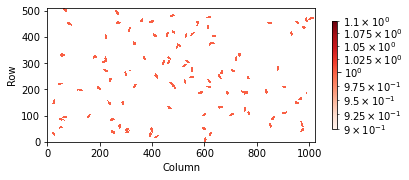

In [2]:
def makeCluster(wx, wy, npix, nclusters = 1):
    cluster=[]
    total_area=0
    for nc in range(nclusters):
        x = np.random.normal(0, wx, npix*5)
        y = np.random.normal(0, wy, npix*5)
        cx = np.random.randint(int(wx*5), 1023-int(wx*5))
        cy = np.random.randint(int(wy*5),  511-int(wy*5))
        angle = np.random.uniform(0, np.pi, 1)
        xr = x*np.cos(angle)+y*np.sin(angle)+cx
        yr = y*np.cos(angle)-x*np.sin(angle)+cy
        x = xr.astype(int)
        y = yr.astype(int)
        
        k = 0
        for i in range(len(x)):
            if ([x[i],y[i]]) not in cluster:
                k+=1
                cluster.append([x[i],y[i]])
        if k == 1: #delete cluster with area 1
            cluster.pop()
        else:
            total_area+=k
        
    return cluster, total_area 

def makeNoise(Noise_points):
    noise=[]
    for i in range(Noise_points):
        nx = np.random.randint(0,1024)
        ny = np.random.randint(0, 512)
        noise.append([nx,ny])
        
    return noise

    
cluster, tot_ar= makeCluster(3,1,10,100)
noise = makeNoise(2)
real=np.append(cluster,noise,axis=0)


#generate the hitmap
cluster_matrix=np.zeros((512,1024))
for pixel in real:
    x=pixel[0]
    y=pixel[1]
    cluster_matrix[y,x] += 1

#and plot it
fig, ax = plt.subplots()
colormap = cm.get_cmap('Reds')
psm = ax.pcolormesh(cluster_matrix, cmap=colormap, norm=colors.LogNorm(), vmin=1, vmax=np.max(cluster_matrix))
cbar=plt.colorbar(psm, shrink=0.5, ax=ax)
#cbar.set_label("N. hits")
plt.axis('scaled')
ax.set(xlim=(0, 1023), ylim=(0, 511))
plt.xlabel("Column")
plt.ylabel("Row")




# Clusterin Algorithm

In [3]:
def findClusterDB_old(X, distance):
    db = DBSCAN(eps=distance, min_samples=2, n_jobs=1).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    nc = 0
    #initialize an empty list to accomodate the sample coordinates whitin the cluster
    clusters = [[] for _ in range(n_clusters_)]
    #total_clusters += n_clusters_
    #total_noise_points += n_noise_
    for j in range(len(db.labels_)):
        if db.labels_[j] == -1:	#noise sample has label -1
            nc = nc + 1	#noise counter
        else: 
            index = db.labels_[j]
            #print(db.components_[j-nc])
            clusters[index].append(np.array(db.components_[j - nc])) 
    Areas=[]
    for j in range(len(clusters)):
        Areas.append(len(clusters[j]))
    return clusters, Areas, nc

#DBSCAN
#Very good noise discrimination
#Good cluster discrimination
#Higher time consuption over Agglomerative clustering
#It works wonders with real data
def findClusterDB(X, distance):
    db = DBSCAN(eps=distance, min_samples=2).fit(X)
    clusters = np.column_stack((X, db.labels_))
    nc = np.sum(clusters[:,2]==-1)
    Noise_inds=np.where(clusters[:,2]==-1)
    clusters=np.delete(clusters,Noise_inds,axis=0)
    labels=np.delete(db.labels_,Noise_inds,axis=0)
    unique, Areas = np.unique(labels, return_counts=True)

    return clusters, Areas, nc

#Agglomerative clustering
#Good noise discrimination with few noise points(upto 1-2 per packet)
#Poor noise discrimination with more noise points(over 4 per packet)
#Cluster discrimination depends on noise density
#Lower time consuption over DBSCAN
#It seems to dislike the real data, BOH
def findClusterAgg(X, distance):
    agg = AgglomerativeClustering(n_clusters=None, distance_threshold=distance, compute_full_tree=True).fit(X)
    clusters = np.column_stack((X, agg.labels_))
    unique, Areas = np.unique(agg.labels_, return_counts=True)
    Noise_inds=[]
    Area_noise_inds=np.array(np.where(Areas==1))
    if len(Area_noise_inds[0]) != 0:
        for index in Area_noise_inds[0]:
            Current_index=np.array(np.where(clusters[:,2]==index))
            Noise_inds=np.append(Noise_inds,Current_index)
        Noise_inds=Noise_inds.astype(int)
        nc=len(Area_noise_inds[0])
        clusters=np.delete(clusters,Noise_inds,axis=0)
        labels=np.delete(agg.labels_,Noise_inds,axis=0)
        unique, Areas = np.unique(labels, return_counts=True)
    else:
        nc=0
    
    return clusters, Areas, nc

#Poor everything, like third world        
def findClusterOPTICS(X, distance):
    opt = OPTICS(eps=distance, min_samples=2, n_jobs=1).fit(X)
    clusters = np.column_stack((X, opt.labels_))
    unique, Areas = np.unique(clusters, return_counts=True)
    nc = np.sum(clusters[:,2]==-1)
     
    return clusters, Areas, nc
        

# Packet decoder simulation with DBSCAN

Completeness : 100.0%
Noise points injected:  2000000
Noise points found:  1496899
Execution time:  680.2398328781128
Exact area:  30.658078709806453
Mean area:  30.719717145074267
Missclassified:  0.36182147110428275 %


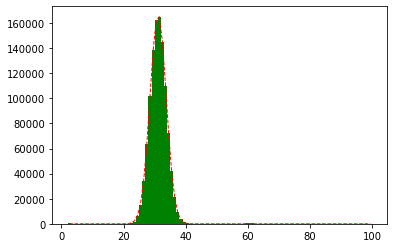

In [4]:
N=200000
patience = 10
#npp=10#noise ponits per packet
Areas=[]
t = time.time()
Tot_area_sim=0
Tot_clusters=0
Tot_noise=0
tot_clust_inj = 0
tot_missclass = 0

for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Nclusters=np.random.randint(1,11)
    Packet, Area_sim=makeCluster(1,2,15,Nclusters)
    npp=np.random.randint(1,15)#noise ponits per packet
    noise=makeNoise(npp)
    realPacket=np.append(Packet,noise,axis=0)
    Tot_area_sim+=Area_sim
    Tot_clusters+=Nclusters
    Cluster, AreaCluster, nc=findClusterDB(realPacket,5)
    Areas=np.append(Areas,AreaCluster)
    tot_missclass += np.abs(len(np.unique(Cluster[:,2])) - Nclusters)
    tot_clust_inj += Nclusters
    Tot_noise+=nc

n, bins, patches = plt.hist(Areas, int(np.max(Areas)-np.min(Areas)), facecolor='g')
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))
popt, pcov = curve_fit(gaussian, xdata=b, ydata=n, p0=[len(Areas), np.mean(Areas), np.std(Areas)])
plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)

print("")
print("Noise points injected: ", N*npp)
print("Noise points found: ", Tot_noise)
print("Execution time: ", time.time()-t)
print("Exact area: ", Tot_area_sim/Tot_clusters)
print("Mean area: ", np.mean(Areas))
print("Missclassified: ", tot_missclass/tot_clust_inj*100, "%")

In [6]:
np.max(Areas)

59.0

[0 1 2 3 4]


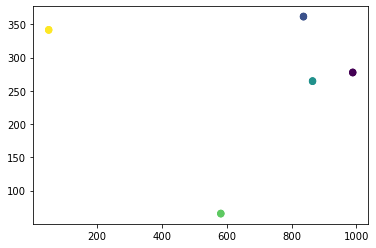

In [7]:
Npackets=np.random.randint(1,10)
clust, Area_sim=makeCluster(0.1,0.1,15,Npackets)
ClusterDC, AreaCluster, _=findClusterDB(clust,1)
plt.scatter(ClusterDC[:,0], ClusterDC[:,1], c=ClusterDC[:,2])

print(np.unique(ClusterDC[:,2]))

# Packet decoder simulation with Agglomerative Clustering

Completeness : 100.0%
Noise points injected:  600000
Noise points found:  1437067
Execution time:  673.4649221897125
Exact area:  30.662624137526606
Mean area:  30.11128717883361
Missclassified:  2.0692997202444974 %


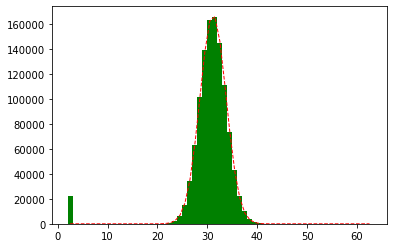

In [5]:
N=200000
patience = 10
#npp=10#noise ponits per packet
Areas=[]
t = time.time()
Tot_area_sim=0
Tot_clusters=0
Tot_noise=0
tot_clust_inj = 0
tot_missclass = 0

for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Nclusters=np.random.randint(1,11)
    Packet, Area_sim=makeCluster(1,2,15,Nclusters)
    npp=np.random.randint(1,15)#noise ponits per packet
    noise=makeNoise(npp)
    realPacket=np.append(Packet,noise,axis=0)
    Tot_area_sim+=Area_sim
    Tot_clusters+=Nclusters
    Cluster, AreaCluster, nc=findClusterAgg(realPacket,25)
    Areas=np.append(Areas,AreaCluster)
    tot_missclass += np.abs(len(np.unique(Cluster[:,2])) - Nclusters)
    tot_clust_inj += Nclusters
    Tot_noise+=nc  

n, bins, patches = plt.hist(Areas, int(np.max(Areas)-np.min(Areas)), facecolor='g')
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))
popt, pcov = curve_fit(gaussian, xdata=b, ydata=n, p0=[len(Areas), np.mean(Areas), np.std(Areas)])
plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)

print("")
print("Noise points injected: ", N*npp)
print("Noise points found: ", Tot_noise)
print("Execution time: ", time.time()-t)
print("Exact area: ", Tot_area_sim/Tot_clusters)
print("Mean area: ", np.mean(Areas))
print("Missclassified: ", tot_missclass/tot_clust_inj*100, "%")

[0 1 2 3 4]


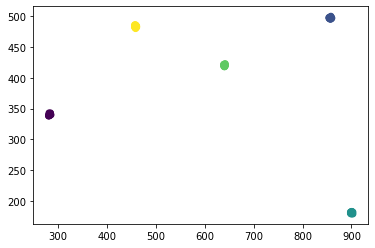

In [9]:
Npackets=5#np.random.randint(5,10)
clust, Area_sim=makeCluster(1,1,15,Npackets)
noise=makeNoise(10)
realclust=np.append(clust,noise,axis=0)
ClusterDC, AreaCluster, _=findClusterAgg(realclust,10)
plt.scatter(ClusterDC[:,0], ClusterDC[:,1], c=ClusterDC[:,2])

print(np.unique(ClusterDC[:,2]))

In [10]:
#LENTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

#N=10000
#patience = 10
#Areas=[]
#t = time.time()
#
#for i in range(N):
#    if ( i % patience == 0 ):
#        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
#    Npackets=np.random.randint(5,10)
#    clust=makeCluster(3,6,15,4,Npackets)
#    ClusterDC, AreaCluster, _=findClusterOPTICS(clust,10)
#    Areas=np.append(Areas,AreaCluster)
#
#print("")  
#print(time.time()-t)
#print(np.mean(Areas))

In [11]:
i = 0
ClusterDB=[]
AreaClusterDB=[]
ncDB=0
ClusterAgg=[]
AreaClusterAgg=[]
ncAgg=0
while True:
    file_name="file{0:0d}.npy".format(i)
    my_file = Path(file_name)
    if my_file.is_file():
        i += 1
        packet = np.load(file_name, allow_pickle=True)
        for k in len(packet):
            Cluster, AreaCluster, nc = findClusterDB(packet[k])
            ClusterDB=np.append(ClusterDB,Cluster)
            AreaClusterDB=np.append(AreaClusterDB,AreaCluster)
            ncDB+=nc
            Cluster, AreaCluster, nc = findClusterAgg(packet[k])
            ClusterAgg=np.append(ClusterAgg,Cluster)
            AreaClusterAgg=np.append(AreaClusterAgg,AreaCluster)
            ncAgg+=nc
    else:
        print ("No more packets to analyze")
        break

No more packets to analyze


# PCA analysis, cluster mean and cosmic discrimination

In [6]:
class ACluster(): #analyzed cluster
    def __init__(self,mean,pca_r,area):
        self.mean=mean #Cluster centroind
        self.pca_r=pca_r#Principal axis variance ratio
        self.area=area #Cluster area
        
def ClusterAnalysisPCA(Cluster):
    pca = PCA(n_components=2)
    pca.fit(Cluster)
    mean=np.array(pca.mean_)
    if pca.explained_variance_ratio_[1]!=0 and pca.explained_variance_ratio_[0]!=0:
        pca_r=(pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1])
    else:
        pca_r=1000
    area=len(Cluster)
    CC=ACluster(mean,pca_r,area)
    
    return CC
    

Text(0, 0.5, 'Row')

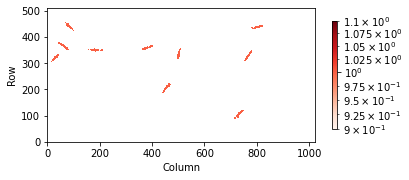

In [24]:
N=100
npp=10
        
Data=[]

for k in range(N):
    Nclusters=10
    Packet, Area_sim=makeCluster(1.5,10,10,Nclusters)
    noise=makeNoise(npp)
    realPacket=np.append(Packet,noise,axis=0)
    Cluster, AreaCluster, nc=findClusterDB(realPacket,7)
    for i in range(len(AreaCluster)):
        Index=np.where(Cluster[:,2]==i)
        C=Cluster[Index]
        CC=ClusterAnalysisPCA(C[:,:2])
        Data.append(CC)

    
#generate the hitmap
cluster_matrix=np.zeros((512,1024))
for pixel in Cluster[:,:2]:
    x=pixel[0]
    y=pixel[1]
    cluster_matrix[y,x] += 1

#and plot it
fig, ax = plt.subplots()
colormap = cm.get_cmap('Reds')
psm = ax.pcolormesh(cluster_matrix, cmap=colormap, norm=colors.LogNorm(), vmin=1, vmax=np.max(cluster_matrix))
cbar=plt.colorbar(psm, shrink=0.5, ax=ax)
#cbar.set_label("N. hits")
plt.axis('scaled')
ax.set(xlim=(0, 1023), ylim=(0, 511))
plt.xlabel("Column")
plt.ylabel("Row")

# Test with real data

PCA_ratio= :2.4449249531025052 +/- 2.2026223047275173 
Area= :5.947318007662835 +/- 4.302287381726502 


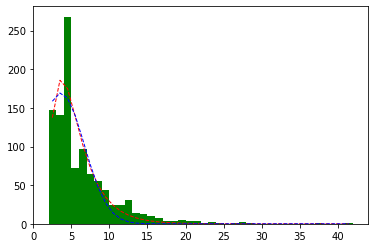

In [14]:
from scipy.stats import moyal

def landaufunc(x,C,mu,scale):
    return C*moyal.pdf(x, mu, scale)

def doublegauss(x, C1, C2, mu1, mu2, s1, s2):
    return gaussian(x,C1,mu1,s1)+gaussian(x,C2,mu2,s2)

XPacket=np.load("Test_data/X.npy")
X2Packet=np.load("Test_data/X2.npy")
ePacket=np.load("Test_data/electron.npy")
aPacket=np.load("Test_data/alpha.npy")
cPacket=np.load("Test_data/cosmic_ray.npy")


Packet=cPacket
Flag_alpha=False
Data=[]
for row in range(512):
    for column in range(1024):
        if Packet[row,column] > 0:
            Data.append([row,column])
            
Cluster, AreaCluster, nc=findClusterDB(Data,1)


#routine to delete overlapping clusters (only present in alpha packet)
THR_index=np.array(np.where(AreaCluster>80))
C_index=[]
if len(THR_index[0]) != 0:
        for index in THR_index[0]:
            Current_index=np.array(np.where(Cluster[:,2]==index))
            C_index=np.append(C_index,Current_index)
        C_index=C_index.astype(int)
        Cluster=np.delete(Cluster,C_index,axis=0)

unique_index = np.unique(Cluster[:,2], return_counts=False)
Data_a=[]

for i in unique_index:
    Index=(np.where(Cluster[:,2]==i))
    C=Cluster[Index]
    CC=ClusterAnalysisPCA(C[:,:2],AreaCluster[i])
    Data_a.append(CC) 

#Need to find better way to get the parameters 
pcaratio=[]
NewArea=[]
for j in range(len(Data_a)):
    NewArea.append(Data_a[j].area)
    if Data_a[j].pca_r !=1000:
        pcaratio.append(Data_a[j].pca_r)
        
n, bins, patches = plt.hist(NewArea, int(np.max(NewArea)-np.min(NewArea)), facecolor='g')
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))

if not Flag_alpha :
    popt_l, pcov_l = curve_fit(landaufunc, xdata=b, ydata=n)
    popt_g, pcov_g = curve_fit(gaussian, xdata=b, ydata=n, p0=[200,np.mean(NewArea),np.std(NewArea)])
#popt, pcov = curve_fit(doublegauss, xdata=b, ydata=n, p0=[300,100,4,15,3,5])
#popt, pcov = curve_fit(gaussian, xdata=b, ydata=n)
else:
    popt, pcov = curve_fit(landaufunc, xdata=b[(range(11,19,1))], ydata=n[(range(11,19,1))])
#plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)   
plt.plot(b, landaufunc(b,popt_l[0],popt_l[1],popt_l[2]), 'r--', linewidth=1)
plt.plot(b, gaussian(b,popt_g[0],popt_g[1],popt_g[2]), 'b--', linewidth=1)


print("PCA_ratio= :{} +/- {} ".format(np.mean(pcaratio), np.std(pcaratio)))
print("Area= :{} +/- {} ".format(np.mean(NewArea), np.std(NewArea)))


           


# Multiprocessing test

In [7]:


def par_findClusterDB(Total_packet,distance):
    input_data=[]
    for packet in Total_packet:
        cd=(packet,7)
        input_data.append(cd)

    pDB=mp.Pool(processes=SET_N_TRHEADS)
    DBresult= pDB.starmap(findClusterDB,input_data,)
    pDB.close()
    pDB.join()
    
    
    return DBresult

def par_findClusterAgg(Total_packet,distance):
    input_data=[]
    for packet in Total_packet:
        cd=(packet,distance,)
        input_data.append(cd)

    pAgg=mp.Pool(processes=SET_N_TRHEADS)
    Aggresult= pAgg.starmap(findClusterAgg,input_data)
    pAgg.close()
    pAgg.join()
    
    
    
    return Aggresult

def par_ClusterAnalysisPCA(parallel_result):
    input_data=[]
    for partial_res in parallel_result:
        unique_labels=np.unique(partial_res[0][:,2], return_counts=False)
        for label in unique_labels:
                Index=np.where(partial_res[0][:,2]==label)
                C=partial_res[0][Index]
                cd=(C[:,:2],)#components with selected label
                input_data.append(cd)
                
    pPCA=mp.Pool(processes=SET_N_TRHEADS)            
    PCAresult=pPCA.starmap(ClusterAnalysisPCA,input_data)
    pPCA.close()
    pPCA.join()
    
   
    
    return PCAresult


In [8]:
N=100000
npp=10
patience=10
Packet_tot=[]
Nclusters=10
for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Packet, Area_sim=makeCluster(1,2,20,Nclusters)
    noise=makeNoise(npp)
    realPacket=np.append(Packet,noise,axis=0)
    Packet_tot.append(realPacket)

Completeness : 100.0%

In [9]:
t=time.time()
Data=[]
for packet in Packet_tot:
    Cluster, AreaCluster, nc=findClusterDB(packet,7)
    for i in range(len(AreaCluster)):
            Index=np.where(Cluster[:,2]==i)
            C=Cluster[Index]
            CC=ClusterAnalysisPCA(C[:,:2])
            Data.append(CC)
            
Serial_t=time.time()-t
print('Completion time with serial processing :',Serial_t)

/home/gabriele/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/gabriele/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/gabriele/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/gabriele/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/gabriele/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enco

Completion time with serial processing : 338.72856426239014


In [ ]:
t=time.time()
DBresult=par_findClusterDB(Packet_tot,7)
Clustering_time=time.time()-t
print('Clustering time with parallel processing :',Clustering_time)

Alaysis_time=time.time()-t
PCAresult=par_ClusterAnalysisPCA(DBresult)
print('Analysis time with parallel processing :',Alaysis_time)
print('Total time with parallel processing :',Clustering_time+Alaysis_time)

Clustering time with parallel processing : 42.91277241706848
